<a href="https://colab.research.google.com/github/raz0208/City-Person-Dataset-EDA/blob/main/CityPerson_LabelFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Augmentation Procsess

In [ ]:
# Instal Required Libraries
import os
import zipfile
import json
import numpy as np
import pandas as pd
from collections import Counter
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Dataset zip files path from Google Drive
gtFine = '/content/drive/MyDrive/CityPersonDataset/gtFine_trainvaltest.zip'
gtFinePanopticParts = '/content/drive/MyDrive/CityPersonDataset/gtFinePanopticParts_trainval.zip'
gtBbox = '/content/drive/MyDrive/CityPersonDataset/gtBbox_cityPersons_trainval.zip'

gtFine_ExtPath = '/content/CityPersonDataset/gtFine_trainvaltest'
gtFinePano_ExtPath = '/content/CityPersonDataset/gtFinePanopticParts_trainval'
gtBbox_ExtPath = '/content/CityPersonDataset/gtBbox_cityPersons_trainval'

In [ ]:
# Extracting files function
def extract_zip(file_path, extract_path):
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Extract both datasets zip files
extract_zip(gtFine, gtFine_ExtPath)
extract_zip(gtFinePanopticParts, gtFinePano_ExtPath)
extract_zip(gtBbox, gtBbox_ExtPath)

In [ ]:
# List the extracted content from both datasets
gtFine_Files = os.listdir(gtFine_ExtPath)
gtFinepano_Files = os.listdir(gtFinePano_ExtPath)
gtBbox_Files = os.listdir(gtBbox_ExtPath)

gtFine_Files, gtFinepano_Files, gtBbox_Files

(['README', 'gtFine', 'license.txt'],
 ['gtFinePanopticParts', 'README_panopticParts.md', 'license.txt'],
 ['gtBboxCityPersons', 'README_cityPersons', 'license.txt'])

In [ ]:
# Path to core folder
gtFine_CorePath = os.path.join(gtFine_ExtPath, 'gtFine')
gtFinePano_CorePath = os.path.join(gtFinePano_ExtPath, 'gtFinePanopticParts')
gtBbox_CorePath = os.path.join(gtBbox_ExtPath, 'gtBboxCityPersons')

# List driectories inside core folders
gtFine_Dirs = os.listdir(gtFine_CorePath) if os.path.exists(gtFine_CorePath) else []
gtFinePano_Dirs = os.listdir(gtFinePano_CorePath) if os.path.exists(gtFinePano_CorePath) else []
gtBbox_Dirs = os.listdir(gtBbox_CorePath) if os.path.exists(gtBbox_CorePath) else []

gtFine_Dirs, gtFinePano_Dirs, gtBbox_Dirs

(['test', 'val', 'train'], ['val', 'train'], ['val', 'train'])

In [ ]:
# Define the subdirectories
subdirs = gtFine_Dirs #["train", "val", "test"]

# Initialize dictionaries to store samples from each subdirectory
gtFine_CityFolders = {}
gtFinePano_CityFolders = {}
gtBbox_CityFolders = {}

# Process each subdirectory
for subdir in subdirs:
    gtFine_CityFolders[subdir] = os.listdir(os.path.join(gtFine_CorePath, subdir)) if subdir in gtFine_Dirs else []
    gtFinePano_CityFolders[subdir] = os.listdir(os.path.join(gtFinePano_CorePath, subdir)) if subdir in gtFinePano_Dirs else []
    gtBbox_CityFolders[subdir] = os.listdir(os.path.join(gtBbox_CorePath, subdir)) if subdir in gtBbox_Dirs else []

# Output the first few files for each subdirectory
gtFine_CityFolders_Preview = {key: value[:] for key, value in gtFine_CityFolders.items()}
gtFinePano_CityFolders_Preview = {key: value[:] for key, value in gtFinePano_CityFolders.items()}
gtBbox_CityFolders_Preview = {key: value[:] for key, value in gtBbox_CityFolders.items()}

gtFine_CityFolders_Preview, gtFinePano_CityFolders_Preview, gtBbox_CityFolders_Preview

({'test': ['bielefeld', 'berlin', 'munich', 'leverkusen', 'mainz', 'bonn'],
  'val': ['lindau', 'munster', 'frankfurt'],
  'train': ['stuttgart',
   'monchengladbach',
   'zurich',
   'erfurt',
   'cologne',
   'darmstadt',
   'strasbourg',
   'bremen',
   'aachen',
   'jena',
   'tubingen',
   'hanover',
   'dusseldorf',
   'krefeld',
   'hamburg',
   'weimar',
   'bochum',
   'ulm']},
 {'test': [],
  'val': ['lindau', 'munster', 'frankfurt'],
  'train': ['stuttgart',
   'monchengladbach',
   'zurich',
   'erfurt',
   'cologne',
   'darmstadt',
   'strasbourg',
   'bremen',
   'aachen',
   'jena',
   'tubingen',
   'hanover',
   'dusseldorf',
   'krefeld',
   'hamburg',
   'weimar',
   'bochum',
   'ulm']},
 {'test': [],
  'val': ['lindau', 'munster', 'frankfurt'],
  'train': ['stuttgart',
   'monchengladbach',
   'zurich',
   'erfurt',
   'cologne',
   'darmstadt',
   'strasbourg',
   'bremen',
   'aachen',
   'jena',
   'tubingen',
   'hanover',
   'dusseldorf',
   'krefeld',
   'ha

In [ ]:
# Initialize dictionaries to store the last file info for each city
# last_file_info_gtFine = {}
# last_file_info_gtFinePano = {}
last_file_info_gtBbox = {}

def get_last_file_info(city_folders, core_path, file_type):
    last_file_info = {}
    for subdir, city_list in city_folders.items():
        last_file_info[subdir] = {}
        for city in city_list:
            city_path = os.path.join(core_path, subdir, city)
            files = [f for f in os.listdir(city_path) if f.endswith(file_type)]
            if files:
                sorted_files = sorted(files, key=lambda x: int(x.split('_')[1])) # Sort by frame number
                last_file = sorted_files[-1]
                parts = last_file.split('_')  # Split the filename
                if len(parts) >= 3: # Check if there are at least 3 parts
                    frame_number1 = parts[1]
                    frame_number2 = parts[2]
                    last_file_info[subdir][city] = {
                        "filename": last_file,
                        "frame_number1": frame_number1,  # Store the 6-digit string directly
                        "frame_number2": frame_number2   # Store the 6-digit string directly
                    }
                else:
                    last_file_info[subdir][city] = None # Handle cases where filename format is incorrect.

            else:
                last_file_info[subdir][city] = None
    return last_file_info

last_file_info_gtBbox = get_last_file_info(gtBbox_CityFolders, gtBbox_CorePath, '_gtBboxCityPersons.json')

print("\nLast file info for gtBbox:")
print(json.dumps(last_file_info_gtBbox, indent=4)) # Use json.dumps for better readability.


Last file info for gtBbox:
{
    "test": {},
    "val": {
        "lindau": {
            "filename": "lindau_000058_000019_gtBboxCityPersons.json",
            "frame_number1": "000058",
            "frame_number2": "000019"
        },
        "munster": {
            "filename": "munster_000173_000019_gtBboxCityPersons.json",
            "frame_number1": "000173",
            "frame_number2": "000019"
        },
        "frankfurt": {
            "filename": "frankfurt_000001_023235_gtBboxCityPersons.json",
            "frame_number1": "000001",
            "frame_number2": "023235"
        }
    },
    "train": {
        "stuttgart": {
            "filename": "stuttgart_000195_000019_gtBboxCityPersons.json",
            "frame_number1": "000195",
            "frame_number2": "000019"
        },
        "monchengladbach": {
            "filename": "monchengladbach_000001_001936_gtBboxCityPersons.json",
            "frame_number1": "000001",
            "frame_number2": "001936"
    

In [ ]:
# Panda dataframe convert function
def create_dataframe_from_last_file_info(last_file_info, dataset_type):
    data = []
    for subdir, city_data in last_file_info.items():
        for city, file_info in city_data.items():
            if file_info:  # Skip cities where no files were found
                data.append({
                    "subdir": subdir,
                    "city": city,
                    "filename": file_info["filename"],
                    "frame_number1": file_info["frame_number1"],
                    "frame_number2": file_info["frame_number2"],
                    "dataset_type": dataset_type  # Add the dataset type
                })
    return pd.DataFrame(data)

# Create DataFrames
#df_gtFine = create_dataframe_from_last_file_info(last_file_info_gtFine, "gtFine")
#df_gtFinePano = create_dataframe_from_last_file_info(last_file_info_gtFinePano, "gtFinePano")
last_file_info_df_gtBbox = create_dataframe_from_last_file_info(last_file_info_gtBbox, "gtBbox")

# # Concatenate all dataframes into a single dataframe (optional)
# all_dfs = [df_gtFine, df_gtFinePano, df_gtBbox]
# df_all = pd.concat(all_dfs, ignore_index=True) #ignore_index=True prevents duplicate index

# Display the DataFrames
# print("gtFine DataFrame:")
# print(df_gtFine)

# print("\ngtFinePano DataFrame:")
# print(df_gtFinePano)

# print("\ngtBbox DataFrame:")
print(last_file_info_df_gtBbox)

# print("\nAll DataFrames (Concatenated):")
# print(df_all)

# Example of saving to CSV:
# df_all.to_csv("last_file_info.csv", index=False)  # Save all info to one csv
# df_gtFine.to_csv("last_gtFine_info.csv", index=False) # Or separate csv files
# df_gtFinePano.to_csv("last_gtFinePano_info.csv", index=False)
last_file_info_df_gtBbox.to_csv("last_gtBbox_info.csv", index=False)

   subdir             city                                           filename  \
0     val           lindau        lindau_000058_000019_gtBboxCityPersons.json   
1     val          munster       munster_000173_000019_gtBboxCityPersons.json   
2     val        frankfurt     frankfurt_000001_023235_gtBboxCityPersons.json   
3   train        stuttgart     stuttgart_000195_000019_gtBboxCityPersons.json   
4   train  monchengladbach  monchengladbach_000001_001936_gtBboxCityPerson...   
5   train           zurich        zurich_000121_000019_gtBboxCityPersons.json   
6   train           erfurt        erfurt_000108_000019_gtBboxCityPersons.json   
7   train          cologne       cologne_000153_000019_gtBboxCityPersons.json   
8   train        darmstadt     darmstadt_000084_000019_gtBboxCityPersons.json   
9   train       strasbourg    strasbourg_000001_010445_gtBboxCityPersons.json   
10  train           bremen        bremen_000315_000019_gtBboxCityPersons.json   
11  train           aachen  

### gtBbox dataset cleaning

##### All json files which contain all labels (classes)

In [ ]:
# Define the required labels to filter them
required_labels = {"pedestrian", "ignore", "rider", "sitting person", "person (other)", "person group"}

# Initialize a list to store filtered file names
filtered_json_files = []

# Process each subdirectory (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    subdir_path = os.path.join(gtBbox_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if it's not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith("_gtBboxCityPersons.json"):
                file_path = os.path.join(city_path, file)

                with open(file_path, "r") as json_file:
                    data = json.load(json_file)

                    # Extract all labels in the current file
                    file_labels = {obj["label"] for obj in data.get("objects", [])}

                    # Check if all required labels are present
                    if required_labels.issubset(file_labels):
                        filtered_json_files.append(file_path)

# Output filtered JSON files
#filtered_json_files

In [ ]:
# Function to show the distribution of each class
def analyze_class_distribution(json_files):
    class_counts = Counter()
    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
        for obj in data['objects']:
            class_counts[obj['label']] += 1
    return class_counts

# Call class distribution function
gtBbox_class_distribution = analyze_class_distribution(filtered_json_files)
print(pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"]))

            Class  Count
0      pedestrian    454
1  sitting person     81
2  person (other)     34
3           rider     36
4          ignore    100
5    person group     88


#### All json files which contains more than one unique label (class)

In [ ]:
filterd_json_files_MoreThanOneLabels = []

# Process each subdirectory (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    subdir_path = os.path.join(gtBbox_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith("_gtBboxCityPersons.json"):
                file_path = os.path.join(city_path, file)

                with open(file_path, "r") as json_file:
                    data = json.load(json_file)

                    # Extract unique labels in the file
                    file_labels = {obj["label"] for obj in data.get("objects", [])}

                    # Check if more than one unique label exists
                    if len(file_labels) > 1:
                        filterd_json_files_MoreThanOneLabels.append(file_path)

# Output filtered JSON files
#filterd_json_files_MoreThanOneLabels

In [ ]:
# Call class distribution function
gtBbox_class_distribution = analyze_class_distribution(filterd_json_files_MoreThanOneLabels)
print(pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"]))

            Class  Count
0      pedestrian  18586
1          ignore   7637
2           rider   2111
3    person group   1569
4  sitting person   1209
5  person (other)    502


In [ ]:
# Count the distribution of file types in a given directory
def count_file_types(directory):
    if not os.path.exists(directory):
      print(f"Error: Directory '{directory}' not found.")
      return None

    file_type_counts = Counter()
    for root, _, files in os.walk(directory):
        for file in files:
            ext = os.path.splitext(file)[-1].lower()
            file_type_counts[ext] += 1
    return file_type_counts

# Analyze file type distribution for gtBboxCityPersons dataset
print("\nFile Type Distribution in gtBboxCityPersons Dataset:")
gtBbox_file_types = count_file_types(gtBbox_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))


File Type Distribution in gtBboxCityPersons Dataset:
  File Type  Count
0     .json   3475


#### Remove json files which contain just "pedestrian", "ignore" labels (classes)

In [ ]:
# Define the specific labels we want to check for removal
target_labels = {"pedestrian", "ignore"}
gtBbox_removed_json_files = 0

# Iterate through subdirectories (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    subdir_path = os.path.join(gtBbox_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith("_gtBboxCityPersons.json"):
                file_path = os.path.join(city_path, file)

                with open(file_path, "r") as json_file:
                    data = json.load(json_file)

                    # Extract unique labels in the file
                    file_labels = {obj["label"] for obj in data.get("objects", [])}

                    # Check if the file contains only "pedestrian" and "ignore"
                    if file_labels == target_labels:
                        os.remove(file_path)  # Remove the JSON file
                        gtBbox_removed_json_files += 1
                        #print(f"Removed: {file_path}")

In [ ]:
# Show the number of removed files
print(f'The number of removed json files: {gtBbox_removed_json_files}')

The number of removed json files: 784


In [ ]:
Removed_json_files = []
Removed_json_files_MoreThanOneLabels = []

# Process each subdirectory (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    subdir_path = os.path.join(gtBbox_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith("_gtBboxCityPersons.json"):
                file_path = os.path.join(city_path, file)

                with open(file_path, "r") as json_file:
                    data = json.load(json_file)
                    Removed_json_files.append(file_path)

                    # Extract unique labels in the file
                    file_labels = {obj["label"] for obj in data.get("objects", [])}

                    # Check if more than one unique label exists
                    if len(file_labels) > 1:
                        Removed_json_files_MoreThanOneLabels.append(file_path)

# # Output removed json files from gtBbox
# Removed_json_files
# # Output removed json files with MoreThanOneLabels filter
# Removed_json_files_MoreThanOneLabels

In [ ]:
# Analyze file type distribution for gtBboxCityPersons dataset
print("\nFile Type Distribution in gtBboxCityPersons Dataset:")
gtBbox_file_types = count_file_types(gtBbox_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))


File Type Distribution in gtBboxCityPersons Dataset:
  File Type  Count
0     .json   2691


In [ ]:
# Check class distribution for gtBbox after cleaning for "Removed_json_files" list
gtBbox_class_distribution = analyze_class_distribution(Removed_json_files)
print(pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"]))

print("\n")

# Check class distribution for gtBbox after cleaning for "Removed_json_files_MoreThanOneLabels" list
gtBbox_class_distribution = analyze_class_distribution(Removed_json_files_MoreThanOneLabels)
print(pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"]))

            Class  Count
0          ignore   6040
1      pedestrian  16354
2           rider   2189
3    person group   1573
4  sitting person   1217
5  person (other)    504


            Class  Count
0           rider   2111
1          ignore   5278
2      pedestrian  15257
3    person group   1569
4  sitting person   1209
5  person (other)    502


#### Replace all "pedestrian" labels with "ignore" in all json files

In [ ]:
# Iterate through subdirectories (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    subdir_path = os.path.join(gtBbox_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith("_gtBboxCityPersons.json"):
                file_path = os.path.join(city_path, file)

                # Read JSON file
                with open(file_path, "r") as json_file:
                    data = json.load(json_file)

                # Modify labels in-place
                modified = False
                for obj in data.get("objects", []):
                    if obj["label"] == "pedestrian":
                        obj["label"] = "ignore"
                        modified = True

                # Write the updated JSON file if any modification was made
                if modified:
                    with open(file_path, "w") as json_file:
                        json.dump(data, json_file, indent=4)
                    # print(f"Updated: {file_path}")

In [ ]:
# Create a list of all JSON files from gtBbox
def get_json_files(directory):
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

NoPedestrain_json_files = get_json_files(gtBbox_CorePath)
#NoPedestrain_json_files

In [ ]:
# Call class distribution function
gtBbox_class_distribution = analyze_class_distribution(NoPedestrain_json_files)
print(pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"]))

            Class  Count
0          ignore  22394
1           rider   2189
2    person group   1573
3  sitting person   1217
4  person (other)    504


In [ ]:
# Define output ZIP file path
output_zip_path = "/content/filtered_cityperson_dataset.zip"

# Function to zip the dataset
def zip_dataset(folder_path, output_path):
    shutil.make_archive(output_path.replace(".zip", ""), 'zip', folder_path)
    print(f"Dataset zipped successfully: {output_path}")

# Zip the dataset
zip_dataset(gtBbox_CorePath, output_zip_path)

# # If running in Colab, provide a download link
# try:
#     from google.colab import files
#     files.download(output_zip_path)
#     print("Download started...")
# except ImportError:
#     print(f"Dataset saved at: {output_zip_path}")

Dataset zipped successfully: /content/filtered_cityperson_dataset.zip


### gtFine Dataset cleaning

Remove all json files in gtFine dataset

In [ ]:
# Analyze file type distribution for gtBboxCityPersons dataset
print("\nFile type distribution in gtFine dataset bevfore removing json files:")
gtBbox_file_types = count_file_types(gtFine_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))


File type distribution in gtFine dataset bevfore removing json files:
  File Type  Count
0      .png  15000
1     .json   5000


In [ ]:
gtFine_removed_json_files = 0

# Iterate through subdirectories (train, val, test)
for subdir in os.listdir(gtFine_CorePath):
    subdir_path = os.path.join(gtFine_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith(".json"):  # Remove all JSON files
                file_path = os.path.join(city_path, file)
                os.remove(file_path)
                gtFine_removed_json_files += 1
                # print(f"Removed: {file_path}")

In [ ]:
# Print the number of removed json files
print(f'The number of json files removed from gtFine dataset: {gtFine_removed_json_files}')

The number of json files removed from gtFine dataset: 5000


In [ ]:
# List remaining files after JSON removal
def list_remaining_files(base_path):
    dataset_structure = {}

    for subdir in os.listdir(base_path):
        subdir_path = os.path.join(base_path, subdir)

        if not os.path.isdir(subdir_path):
            continue  # Skip if not a directory

        dataset_structure[subdir] = {}

        for city in os.listdir(subdir_path):
            city_path = os.path.join(subdir_path, city)

            if not os.path.isdir(city_path):
                continue

            # List remaining files in the city folder
            remaining_files = [f for f in os.listdir(city_path) if not f.endswith(".json")]
            dataset_structure[subdir][city] = remaining_files

    return dataset_structure

# Get the dataset structure after JSON removal
gtFineDS_jsonRemoved = list_remaining_files(gtFine_CorePath)

# Print the structure
# print(json.dumps(gtFineDS_jsonRemoved, indent=4))

In [ ]:
# Analyze file type distribution for gtBboxCityPersons dataset
print("\nFile type distribution in gtFine dataset after removing json files:")
gtBbox_file_types = count_file_types(gtFine_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))


File type distribution in gtFine dataset after removing json files:
  File Type  Count
0      .png  15000


### gtFinePanopticParts dataset

In [ ]:
# Analyze file type distribution for gtFinePanopticParts dataset
print("\nFile type distribution in gtFine dataset after removing json files:")
gtBbox_file_types = count_file_types(gtFinePano_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))


File type distribution in gtFine dataset after removing json files:
  File Type  Count
0      .tif   3475


### Syncronizing Datasets


In [ ]:
#############################################
# # Define dataset paths
# gtFine_Final_CorePath = gtFine_CorePath  # .png files
# gtFinePano_Final_CorePath = gtFinePano_CorePath  # .tif files
# gtBbox_Final_CorePath = gtBbox_CorePath  # Reference dataset

Removing "test" directory from each dataset if it excits.

In [ ]:
# Remove "test" folder if it exists in each dataset
for dataset_path in [gtFine_CorePath, gtFinePano_CorePath, gtBbox_CorePath]:
    test_folder_path = os.path.join(dataset_path, "test")
    if os.path.exists(test_folder_path) and os.path.isdir(test_folder_path):
        for root, dirs, files in os.walk(test_folder_path, topdown=False):
            for file in files:
                os.remove(os.path.join(root, file))
            for dir in dirs:
                os.rmdir(os.path.join(root, dir))
        os.rmdir(test_folder_path)
        print(f"Removed test folder: {test_folder_path}")

Removed test folder: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/test


In [ ]:
# Analyze file type distribution for gtFinePanopticParts dataset
print("\nFile type distribution in gtFine dataset after removing json files:")
gtBbox_file_types = count_file_types(gtFine_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))

# Analyze file type distribution for gtFinePanopticParts dataset
print("\nFile type distribution in gtFine dataset after removing json files:")
gtBbox_file_types = count_file_types(gtFinePano_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))

# Analyze file type distribution for gtFinePanopticParts dataset
print("\nFile type distribution in gtFine dataset after removing json files:")
gtBbox_file_types = count_file_types(gtBbox_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))


File type distribution in gtFine dataset after removing json files:
  File Type  Count
0      .png  10425

File type distribution in gtFine dataset after removing json files:
  File Type  Count
0      .tif   3475

File type distribution in gtFine dataset after removing json files:
  File Type  Count
0     .json   2691


Removing unmatched files in all datasets

In [ ]:
# Iterate through subdirectories (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    gtBbox_subdir_path = os.path.join(gtBbox_CorePath, subdir)
    gtFine_subdir_path = os.path.join(gtFine_CorePath, subdir)
    gtFinePano_subdir_path = os.path.join(gtFinePano_CorePath, subdir)

    if not os.path.isdir(gtBbox_subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(gtBbox_subdir_path):
        gtBbox_city_path = os.path.join(gtBbox_subdir_path, city)
        gtFine_city_path = os.path.join(gtFine_subdir_path, city)
        gtFinePano_city_path = os.path.join(gtFinePano_subdir_path, city)

        if not os.path.isdir(gtBbox_city_path):
            continue  # Skip if not a directory

        # Get reference file names (first part before '_') from gtBbox
        gtBbox_files = {"_".join(f.split("_")[:3]) for f in os.listdir(gtBbox_city_path)}

        # Remove unmatched files from gtFine (.png format)
        if os.path.exists(gtFine_city_path):
            for file in os.listdir(gtFine_city_path):
                file_prefix = "_".join(file.split("_")[:3])  # Extract city name and frame number
                if file_prefix not in gtBbox_files:
                    os.remove(os.path.join(gtFine_city_path, file))
                    # print(f"Removed: {os.path.join(gtFine_city_path, file)}")

        # Remove unmatched files from gtFinePano (.tif format)
        if os.path.exists(gtFinePano_city_path):
            for file in os.listdir(gtFinePano_city_path):
                file_prefix = "_".join(file.split("_")[:3])  # Extract city name and frame number
                if file_prefix not in gtBbox_files:
                    os.remove(os.path.join(gtFinePano_city_path, file))
                    # print(f"Removed: {os.path.join(gtFinePano_city_path, file)}")

In [ ]:
from google.colab import files

# Define output ZIP file path
output_zip_path_gtBbox = "/content/filtered_gtBbox.zip"
output_zip_path_gtFine = "/content/filtered_gtFine.zip"
output_zip_path_gtFinePano = "/content/filtered_gtFinePano.zip"

# Function to zip the dataset
def zip_dataset(folder_path, output_path):
    shutil.make_archive(output_path.replace(".zip", ""), 'zip', folder_path)
    print(f"Dataset zipped successfully: {output_path}")

# Zip the dataset
zip_dataset(gtBbox_CorePath, output_zip_path_gtBbox)
# If running in Colab, provide a download link
# try:
#     files.download(output_zip_path_gtBbox)
#     print("Download started...")
# except ImportError:
#     print(f"Dataset saved at: {output_zip_path_gtBbox}")

zip_dataset(gtFine_CorePath, output_zip_path_gtFine)
# If running in Colab, provide a download link
# try:
#     files.download(output_zip_path_gtFine)
#     print("Download started...")
# except ImportError:
#     print(f"Dataset saved at: {output_zip_path_gtFine}")

zip_dataset(gtFinePano_CorePath, output_zip_path_gtFinePano)
# If running in Colab, provide a download link
# try:
#     files.download(output_zip_path_gtFinePano)
#     print("Download started...")
# except ImportError:
#     print(f"Dataset saved at: {output_zip_path_gtFinePano}")

Dataset zipped successfully: /content/filtered_gtBbox.zip
Dataset zipped successfully: /content/filtered_gtFine.zip
Dataset zipped successfully: /content/filtered_gtFinePano.zip


Check the datasets after cleaning based on filtered gtBbox json files.

In [ ]:
# # Path to core folder
# gtFine_CorePath = os.path.join(gtFine_ExtPath, 'gtFine')
# gtFinePano_CorePath = os.path.join(gtFinePano_ExtPath, 'gtFinePanopticParts')
# gtBbox_CorePath = os.path.join(gtBbox_ExtPath, 'gtBboxCityPersons')

# List driectories inside core folders
gtFine_Dirs = os.listdir(gtFine_CorePath) if os.path.exists(gtFine_CorePath) else []
gtFinePano_Dirs = os.listdir(gtFinePano_CorePath) if os.path.exists(gtFinePano_CorePath) else []
gtBbox__Dirs = os.listdir(gtBbox_CorePath) if os.path.exists(gtBbox_CorePath) else []

gtFine_Dirs, gtFinePano_Dirs, gtBbox_Dirs

(['val', 'train'], ['val', 'train'], ['val', 'train'])

In [ ]:
# Define the subdirectories
subdirs = gtFine_Dirs #["train", "val"]

# Initialize dictionaries to store samples from each subdirectory
gtFine_CityFolders = {}
gtFinePano_CityFolders = {}
gtBbox_CityFolders = {}

# Process each subdirectory
for subdir in subdirs:
    gtFine_CityFolders[subdir] = os.listdir(os.path.join(gtFine_CorePath, subdir)) if subdir in gtFine_Dirs else []
    gtFinePano_CityFolders[subdir] = os.listdir(os.path.join(gtFinePano_CorePath, subdir)) if subdir in gtFinePano_Dirs else []
    gtBbox_CityFolders[subdir] = os.listdir(os.path.join(gtBbox_CorePath, subdir)) if subdir in gtBbox_Dirs else []

# Output the first few files for each subdirectory
gtFine_CityFolders_Preview = {key: value[:] for key, value in gtFine_CityFolders.items()}
gtFinePano_CityFolders_Preview = {key: value[:] for key, value in gtFinePano_CityFolders.items()}
gtBbox_CityFolders_Preview = {key: value[:] for key, value in gtBbox_CityFolders.items()}

gtFine_CityFolders_Preview, gtFinePano_CityFolders_Preview, gtBbox_CityFolders_Preview

({'val': ['lindau', 'munster', 'frankfurt'],
  'train': ['stuttgart',
   'monchengladbach',
   'zurich',
   'erfurt',
   'cologne',
   'darmstadt',
   'strasbourg',
   'bremen',
   'aachen',
   'jena',
   'tubingen',
   'hanover',
   'dusseldorf',
   'krefeld',
   'hamburg',
   'weimar',
   'bochum',
   'ulm']},
 {'val': ['lindau', 'munster', 'frankfurt'],
  'train': ['stuttgart',
   'monchengladbach',
   'zurich',
   'erfurt',
   'cologne',
   'darmstadt',
   'strasbourg',
   'bremen',
   'aachen',
   'jena',
   'tubingen',
   'hanover',
   'dusseldorf',
   'krefeld',
   'hamburg',
   'weimar',
   'bochum',
   'ulm']},
 {'val': ['lindau', 'munster', 'frankfurt'],
  'train': ['stuttgart',
   'monchengladbach',
   'zurich',
   'erfurt',
   'cologne',
   'darmstadt',
   'strasbourg',
   'bremen',
   'aachen',
   'jena',
   'tubingen',
   'hanover',
   'dusseldorf',
   'krefeld',
   'hamburg',
   'weimar',
   'bochum',
   'ulm']})

In [ ]:
# File type distribution for gtFine_Final dataset
print("File Type Distribution in gtFine Dataset:")
gtFine_file_types = count_file_types(gtFine_CorePath)
print(pd.DataFrame(gtFine_file_types.items(), columns=["File Type", "Count"]))

# Analyze file type distribution for gtFinePanopticParts_Final dataset
print("\nFile Type Distribution in gtFinePanopticParts Dataset:")
gtFinePano_file_types = count_file_types(gtFinePano_CorePath)
print(pd.DataFrame(gtFinePano_file_types.items(), columns=["File Type", "Count"]))

# Analyze file type distribution for gtBboxCityPersons_Final dataset
print("\nFile Type Distribution in gtBboxCityPersons Dataset:")
gtBbox_file_types = count_file_types(gtBbox_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))

File Type Distribution in gtFine Dataset:
  File Type  Count
0      .png   8073

File Type Distribution in gtFinePanopticParts Dataset:
  File Type  Count
0      .tif   2691

File Type Distribution in gtBboxCityPersons Dataset:
  File Type  Count
0     .json   2691


#### Validate image and annotation files

In [ ]:
# Select 3 cities name randomly from 'train' folder to check files
selected_cities = random.sample(gtFine_CityFolders['train'], 3)

# List files for each selected city
gtFine_city_files = {}
gtFinePano_city_files = {}
gtBbox_city_files = {}
gtFine_city_files_sorted = {}
gtFinePano_city_files_sorted = {}
gtBbox_city_files_sorted = {}

for city in selected_cities:
    gtFine_city_path = os.path.join(gtFine_CorePath, "train", city)
    gtFinePano_city_path = os.path.join(gtFinePano_CorePath, "train", city)
    gtBbox_city_path = os.path.join(gtBbox_CorePath, "train", city)

    gtFine_city_files[city] = sorted(os.listdir(gtFine_city_path) if os.path.exists(gtFine_city_path) else [])
    gtFinePano_city_files[city] = sorted(os.listdir(gtFinePano_city_path) if os.path.exists(gtFinePano_city_path) else [])
    gtBbox_city_files[city] = sorted(os.listdir(gtBbox_city_path) if os.path.exists(gtBbox_city_path) else [])

    gtFine_city_files_sorted[city] = gtFine_city_files[city][:3]
    gtFinePano_city_files_sorted[city] = gtFinePano_city_files[city][:1]
    gtBbox_city_files_sorted[city] = gtBbox_city_files[city][:1]

# Preview sample files for each city
gtFine_city_files_sorted, gtFinePano_city_files_sorted, gtBbox_city_files_sorted

({'ulm': ['ulm_000000_000019_gtFine_color.png',
   'ulm_000000_000019_gtFine_instanceIds.png',
   'ulm_000000_000019_gtFine_labelIds.png'],
  'bremen': ['bremen_000000_000019_gtFine_color.png',
   'bremen_000000_000019_gtFine_instanceIds.png',
   'bremen_000000_000019_gtFine_labelIds.png'],
  'cologne': ['cologne_000000_000019_gtFine_color.png',
   'cologne_000000_000019_gtFine_instanceIds.png',
   'cologne_000000_000019_gtFine_labelIds.png']},
 {'ulm': ['ulm_000000_000019_gtFinePanopticParts.tif'],
  'bremen': ['bremen_000000_000019_gtFinePanopticParts.tif'],
  'cologne': ['cologne_000000_000019_gtFinePanopticParts.tif']},
 {'ulm': ['ulm_000000_000019_gtBboxCityPersons.json'],
  'bremen': ['bremen_000000_000019_gtBboxCityPersons.json'],
  'cologne': ['cologne_000000_000019_gtBboxCityPersons.json']})

In [ ]:
# Parse a JSON annotation file function
def parse_json_file(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    print("Keys in JSON file:", data.keys())
    return data

# Create a list of all JSON files from gtFine
def get_json_files(directory):
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

gtBbox_json_files = get_json_files(gtBbox_CorePath)
#gtBbox_json_files

Randomly Selected JSON file: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/krefeld/krefeld_000000_036299_gtBboxCityPersons.json
Keys in JSON file: dict_keys(['imgHeight', 'imgWidth', 'objects'])
Corresponding TIF file: /content/CityPersonDataset/gtFinePanopticParts_trainval/gtFinePanopticParts/train/krefeld/krefeld_000000_036299_gtFinePanopticParts.tif


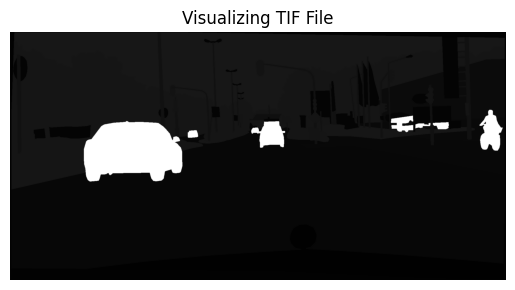

In [ ]:
# Randomly select a JSON file from gtBbox
if not gtBbox_json_files:
    print("No JSON files found in gtFine dataset.")
else:
    sample_json = random.choice(gtBbox_json_files)
    print(f"Randomly Selected JSON file: {sample_json}")
    sample_gtBbox_data = parse_json_file(sample_json)

    # Derive the corresponding .tif file path in gtFinePanopticParts
    json_filename = os.path.basename(sample_json)
    tif_filename = json_filename.replace('_gtBboxCityPersons.json', '_gtFinePanopticParts.tif')

    tif_file_path = None
    for root, _, files in os.walk(gtFinePano_CorePath):
        for file in files:
            if file == tif_filename:
                tif_file_path = os.path.join(root, file)
                break
        if tif_file_path:
            break

    # Visualize the .tif file if it exists
    if tif_file_path:
        print(f"Corresponding TIF file: {tif_file_path}")
        tif_image = Image.open(tif_file_path)
        plt.imshow(tif_image)
        plt.title("Visualizing TIF File")
        plt.axis('off')  # Turn off axis for better visualization
        plt.show()
    else:
        print(f"No corresponding TIF file found for {sample_json}")

In [ ]:
sample_gtBbox_data

{'imgHeight': 1024,
 'imgWidth': 2048,
 'objects': [{'instanceId': 25000,
   'bbox': [1957, 323, 57, 138],
   'bboxVis': [1957, 325, 57, 127],
   'label': 'rider'},
  {'instanceId': 0,
   'bbox': [1527, 310, 12, 10],
   'bboxVis': [1527, 310, 12, 10],
   'label': 'ignore'}]}

### Change the color of "ignore" labels

In [ ]:
# Function to process a single .tif file
def process_tif_file(tif_path, json_path, background_color=(0, 0, 0)):  # Default background: black
    try:
        img = Image.open(tif_path).convert("RGB")  # Open as RGB to handle potential paletted images
        img_array = np.array(img)

        with open(json_path, 'r') as f:
            data = json.load(f)

        for obj in data.get('objects', []):
            if obj['label'] == 'ignore':
                bbox = obj['bbox']
                x_min, y_min, width, height = bbox
                x_max = x_min + width
                y_max = y_min + height

                # Ensure bounding box coordinates are within image bounds
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(img_array.shape[1], x_max)
                y_max = min(img_array.shape[0], y_max)

                img_array[y_min:y_max, x_min:x_max] = background_color  # Set pixels within bbox to background color

        updated_img = Image.fromarray(img_array)
        updated_img.save(tif_path)  # Save the updated .tif image, overwriting the original
        # print(f"Processed: {tif_path}")

    except Exception as e:
        print(f"Error processing {tif_path}: {e}")


# Iterate through subdirectories (train, val)
for subdir in os.listdir(gtBbox_CorePath):
    gtBbox_subdir_path = os.path.join(gtBbox_CorePath, subdir)
    gtFinePano_subdir_path = os.path.join(gtFinePano_CorePath, subdir)

    if not os.path.isdir(gtBbox_subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(gtBbox_subdir_path):
        gtBbox_city_path = os.path.join(gtBbox_subdir_path, city)
        gtFinePano_city_path = os.path.join(gtFinePano_subdir_path, city)

        if not os.path.isdir(gtBbox_city_path):
            continue  # Skip if not a directory

        for file in os.listdir(gtBbox_city_path):
            if file.endswith("_gtBboxCityPersons.json"):
                json_file = file
                tif_file = json_file.replace("_gtBboxCityPersons.json", "_gtFinePanopticParts.tif")

                json_path = os.path.join(gtBbox_city_path, json_file)
                tif_path = os.path.join(gtFinePano_city_path, tif_file)

                if os.path.exists(tif_path):  # Check if the corresponding .tif exists
                    process_tif_file(tif_path, json_path)
                else:
                    print(f"Warning: TIF file not found for {json_file}")

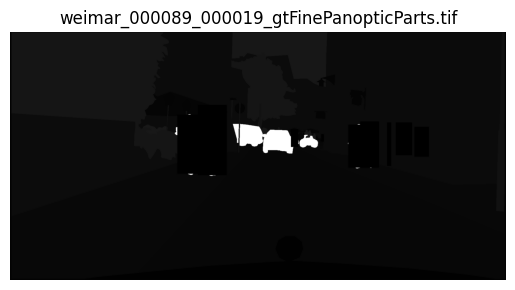

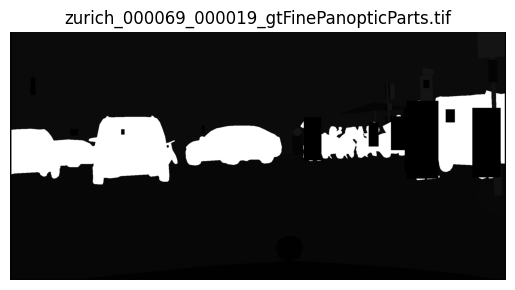

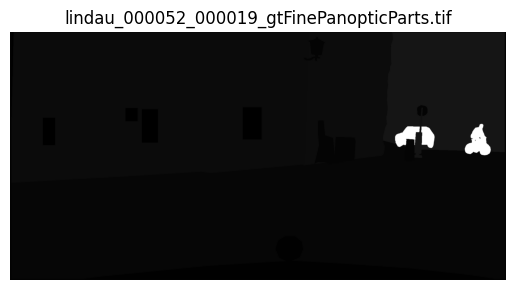

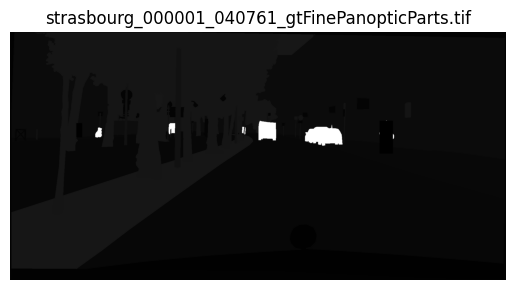

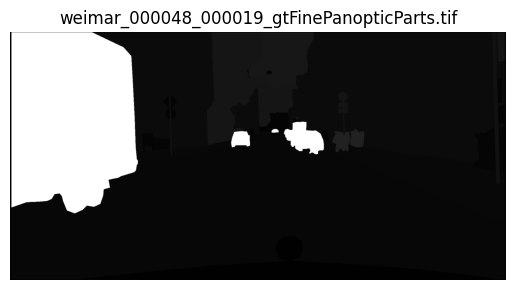

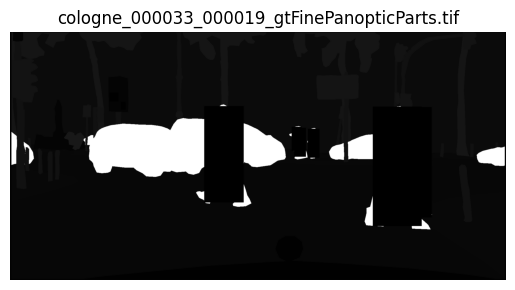

In [ ]:
# Sample Visualization (after processing all files)
def display_sample_images(num_samples=6):
    all_tif_files = []
    for root, _, files in os.walk(gtFinePano_CorePath):
        for file in files:
            if file.endswith(".tif"):
                all_tif_files.append(os.path.join(root, file))

    if not all_tif_files:
        print("No .tif files found.")
        return

    sample_files = random.sample(all_tif_files, min(num_samples, len(all_tif_files)))

    for tif_file in sample_files:
        img = Image.open(tif_file)
        plt.imshow(img)
        plt.title(os.path.basename(tif_file))
        plt.axis('off')
        plt.show()

display_sample_images()

### This part is for test ⬇

In [ ]:
# ##################################
# # Define output ZIP file path
# processed_zip_path_gtBbox = "/content/processed_gtBbox.zip"
# # processed_zip_path_gtFine = "/content/processed_gtFine.zip"
# processed_zip_path_gtFinePano = "/content/processed_gtFinePano.zip"

# # Function to zip the dataset
# def zip_dataset(folder_path, output_path):
#     shutil.make_archive(output_path.replace(".zip", ""), 'zip', folder_path)
#     print(f"Dataset zipped successfully: {output_path}")

# # Zip the dataset
# zip_dataset(gtBbox_CorePath, processed_zip_path_gtBbox)
# #zip_dataset(gtFine_CorePath, processed_zip_path_gtFine)
# zip_dataset(gtFinePano_CorePath, processed_zip_path_gtFinePano)

In [ ]:
# # Dataset zip files path from Google Drive
# processed_path_gtBbox = '/content/processed_gtBbox.zip'
# processed_zip_path_gtFinePano = '/content/processed_gtFinePano.zip'

# processed_gtFinePano_ExtPath = '/content/ProcessedDataset/gtFinePanopticParts_trainval'
# processed_gtBbox_ExtPath = '/content/ProcessedDataset/gtBbox_cityPersons_trainval'

In [ ]:
# # Extract both datasets zip files
# extract_zip(processed_zip_path_gtFinePano, processed_gtFinePano_ExtPath)
# extract_zip(processed_path_gtBbox, processed_gtBbox_ExtPath)

In [ ]:
#!rm -rf /content/ProcessedDataset

In [ ]:
# # # File type distribution for gtFine_Final dataset
# # print("File Type Distribution in gtFine Dataset:")
# # gtFine_file_types = count_file_types(gtFine_CorePath)
# # print(pd.DataFrame(gtFine_file_types.items(), columns=["File Type", "Count"]))

# # Analyze file type distribution for gtFinePanopticParts_Final dataset
# print("\nFile Type Distribution in gtFinePanopticParts Dataset:")
# gtFinePano_file_types = count_file_types(processed_gtFinePano_ExtPath)
# print(pd.DataFrame(gtFinePano_file_types.items(), columns=["File Type", "Count"]))

# # Analyze file type distribution for gtBboxCityPersons_Final dataset
# print("\nFile Type Distribution in gtBboxCityPersons Dataset:")
# gtBbox_file_types = count_file_types(processed_gtBbox_ExtPath)
# print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))

### End of test part ⬆

### Rename all files in each city based on last number of frame

In [ ]:
last_file_info_df_gtBbox
#last_file_info_gtBbox

,subdir,city,filename,frame_number1,frame_number2,dataset_type
0,val,lindau,lindau_000058_000019_gtBboxCityPersons.json,000058,000019,gtBbox
1,val,munster,munster_000173_000019_gtBboxCityPersons.json,000173,000019,gtBbox
2,val,frankfurt,frankfurt_000001_023235_gtBboxCityPersons.json,000001,023235,gtBbox
3,train,stuttgart,stuttgart_000195_000019_gtBboxCityPersons.json,000195,000019,gtBbox
4,train,monchengladbach,monchengladbach_000001_001936_gtBboxCityPerson...,000001,001936,gtBbox
5,train,zurich,zurich_000121_000019_gtBboxCityPersons.json,000121,000019,gtBbox
6,train,erfurt,erfurt_000108_000019_gtBboxCityPersons.json,000108,000019,gtBbox
7,train,cologne,cologne_000153_000019_gtBboxCityPersons.json,000153,000019,gtBbox
8,train,darmstadt,darmstadt_000084_000019_gtBboxCityPersons.json,000084,000019,gtBbox
9,train,strasbourg,strasbourg_000001_010445_gtBboxCityPersons.json,000001,010445,gtBbox


In [ ]:
# Function to rename all files
def rename_files(core_path, last_file_info_df):
    for index, row in last_file_info_df.iterrows():
        subdir = row['subdir']
        city = row['city']
        last_frame_number = int(row['frame_number1'])

        for filename in os.listdir(os.path.join(core_path, subdir, city)):
            if filename.endswith(("_gtBboxCityPersons.json", "_gtFinePanopticParts.tif")):
                parts = filename.split("_")
                if len(parts) >= 4:
                    frame_number1 = parts[1]
                    frame_number2 = parts[2]
                    new_frame_number1 = None

                    if frame_number2 == "000019":
                        frame_number1_int = int(frame_number1)
                        new_frame_number1 = str(last_frame_number + frame_number1_int + 1).zfill(6)
                    else:
                        new_frame_number1 = "000002"

                    if new_frame_number1:
                        new_filename = f"{parts[0]}_{new_frame_number1}_{frame_number2}_{parts[3]}"
                        old_path = os.path.join(core_path, subdir, city, filename)
                        new_path = os.path.join(core_path, subdir, city, new_filename)
                        os.rename(old_path, new_path)
                        #print(f"Renamed: {old_path} to {new_path}")

# Call the rename function for "gtBbox_CorePath" dataset
rename_files(gtBbox_CorePath, last_file_info_df_gtBbox)
# Call the rename function for "gtFinePano_CorePath" dataset
rename_files(gtFinePano_CorePath, last_file_info_df_gtBbox)

In [ ]:
# File type distribution for gtFine_Final dataset
print("File Type Distribution in gtFine Dataset:")
gtFine_file_types = count_file_types(gtFine_CorePath)
print(pd.DataFrame(gtFine_file_types.items(), columns=["File Type", "Count"]))

# Analyze file type distribution for gtFinePanopticParts_Final dataset
print("\nFile Type Distribution in gtFinePanopticParts Dataset:")
gtFinePano_file_types = count_file_types(gtFinePano_CorePath)
print(pd.DataFrame(gtFinePano_file_types.items(), columns=["File Type", "Count"]))

# Analyze file type distribution for gtBboxCityPersons_Final dataset
print("\nFile Type Distribution in gtBboxCityPersons Dataset:")
gtBbox_file_types = count_file_types(gtBbox_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))

File Type Distribution in gtFine Dataset:
  File Type  Count
0      .png   8073

File Type Distribution in gtFinePanopticParts Dataset:
  File Type  Count
0      .tif   2691

File Type Distribution in gtBboxCityPersons Dataset:
  File Type  Count
0     .json   2691


In [ ]:
# Define output ZIP file path
renamed_zip_path_gtBbox = "/content/renamed_gtBbox.zip"
#renamed_zip_path_gtFine = "/content/renamed_gtFine.zip"
renamed_zip_path_gtFinePano = "/content/renamed_gtFinePano.zip"

# Function to zip the dataset
def zip_dataset(folder_path, output_path):
    shutil.make_archive(output_path.replace(".zip", ""), 'zip', folder_path)
    print(f"Dataset zipped successfully: {output_path}")

# Zip the dataset
zip_dataset(gtBbox_CorePath, renamed_zip_path_gtBbox)
#zip_dataset(gtFine_CorePath, renamed_zip_path_gtFine)
zip_dataset(gtFinePano_CorePath, renamed_zip_path_gtFinePano)

Dataset zipped successfully: /content/renamed_gtBbox.zip
Dataset zipped successfully: /content/renamed_gtFinePano.zip


### Add processed and renamed files to original dataset

Re-read and re-extract original files

In [ ]:
# Dataset zip files path from Google Drive
#gtFine_Org = '/content/drive/MyDrive/CityPersonDataset/gtFine_trainvaltest.zip'
gtFinePanopticParts_Org = '/content/drive/MyDrive/CityPersonDataset/gtFinePanopticParts_trainval.zip'
gtBbox_Org = '/content/drive/MyDrive/CityPersonDataset/gtBbox_cityPersons_trainval.zip'

#gtFine_Org_ExtPath = '/content/CityPersonDataset_Org/gtFine_trainvaltest'
gtFinePano_Org_ExtPath = '/content/CityPersonDataset_Org/gtFinePanopticParts_trainval'
gtBbox_Org_ExtPath = '/content/CityPersonDataset_Org/gtBbox_cityPersons_trainval'

In [ ]:
# Extract both datasets zip files
# extract_zip(gtFine_Org, gtFine_ExtPath)
extract_zip(gtFinePanopticParts_Org, gtFinePano_Org_ExtPath)
extract_zip(gtBbox_Org, gtBbox_Org_ExtPath)

In [ ]:
# Path to core folder
# gtFine_Org_CorePath = os.path.join(gtFine_Org_ExtPath, 'gtFine')
gtFinePano_Org_CorePath = os.path.join(gtFinePano_Org_ExtPath, 'gtFinePanopticParts')
gtBbox_Org_CorePath = os.path.join(gtBbox_Org_ExtPath, 'gtBboxCityPersons')

In [ ]:
# !rm -rf /content/CityPersonDataset_Org

### Merge the processed dataset to orginal one

In [ ]:
# Define the source and destination paths
source_paths = {
    "gtFinePano": gtFinePano_CorePath,
    "gtBbox": gtBbox_CorePath
}
destination_paths = {
    "gtFinePano": gtFinePano_Org_CorePath,
    "gtBbox": gtBbox_Org_CorePath
}

# Iterate through the datasets
for dataset_type in ["gtFinePano", "gtBbox"]:
    source_base_path = source_paths[dataset_type]
    destination_base_path = destination_paths[dataset_type]

    # Iterate through subdirectories (train, val)
    for subdir in ["train", "val"]:
        source_subdir_path = os.path.join(source_base_path, subdir)
        destination_subdir_path = os.path.join(destination_base_path, subdir)

        # Iterate through cities
        for city in os.listdir(source_subdir_path):
            source_city_path = os.path.join(source_subdir_path, city)
            destination_city_path = os.path.join(destination_subdir_path, city)

            # Copy files from source to destination
            for file in os.listdir(source_city_path):
                source_file_path = os.path.join(source_city_path, file)
                destination_file_path = os.path.join(destination_city_path, file)
                shutil.copy2(source_file_path, destination_file_path)
                #print(f"Copied: {source_file_path} -> {destination_file_path}")

print("All processed files copied to original dataset structure.")

All processed files copied to original dataset structure.


In [ ]:
# Function for image and json file verification
def verify_merge(source_paths, destination_paths):
    verification_results = {}
    file_type_counts = {}  # Store file type counts

    for dataset_type in source_paths:
        verification_results[dataset_type] = {}
        file_type_counts[dataset_type] = {}

        source_base_path = source_paths[dataset_type]
        destination_base_path = destination_paths[dataset_type]

        for subdir in ["train", "val"]:
            source_subdir_path = os.path.join(source_base_path, subdir)
            destination_subdir_path = os.path.join(destination_base_path, subdir)

            if not os.path.exists(source_subdir_path) or not os.path.exists(destination_subdir_path):
                print(f"Warning: Subdirectory {subdir} not found in one or both of the paths for {dataset_type}")
                continue

            for city in os.listdir(source_subdir_path):
                source_city_path = os.path.join(source_subdir_path, city)
                destination_city_path = os.path.join(destination_subdir_path, city)

                if not os.path.isdir(source_city_path) or not os.path.isdir(destination_city_path):
                    print(f"Warning: City {city} not found in one or both of the paths for {dataset_type}")
                    continue

                source_files = set(os.listdir(source_city_path))
                destination_files = set(os.listdir(destination_city_path))

                # Check if all source files are present in the destination
                files_match = source_files.issubset(destination_files)

                verification_results[dataset_type][city] = files_match

                if not files_match:
                    print(f"Mismatch in {dataset_type} - {subdir} - {city}:")
                    files_only_in_source = source_files - destination_files
                    if files_only_in_source:
                        print(f"  Files only in source: {files_only_in_source}")

                    files_only_in_dest = destination_files - source_files
                    if files_only_in_dest:
                        print(f"  Files only in destination: {files_only_in_dest}")

                # Count file types for source
                file_type_counts[dataset_type].setdefault("source", Counter())
                for file in source_files:
                    ext = os.path.splitext(file)[-1].lower()
                    file_type_counts[dataset_type]["source"][ext] += 1

                # Count file types for destination
                file_type_counts[dataset_type].setdefault("destination", Counter())
                for file in destination_files:
                    ext = os.path.splitext(file)[-1].lower()
                    file_type_counts[dataset_type]["destination"][ext] += 1

    return verification_results, file_type_counts


# Define the source and destination paths
# source_paths = {
#     "gtFinePano": gtFinePano_CorePath,
#     "gtBbox": gtBbox_CorePath
# }
# destination_paths = {
#     "gtFinePano": gtFinePano_Org_CorePath,
#     "gtBbox": gtBbox_Org_CorePath
# }

# Call files verification function
verification_results, file_type_counts = verify_merge(source_paths, destination_paths)


# Print Verification Results
for dataset, cities in verification_results.items():
    print(f"\nVerification Results for {dataset}:")
    for city, match in cities.items():
        print(f"  {city}: {'Match' if match else 'Mismatch'}")

# Print File Type Counts
for dataset, counts in file_type_counts.items():
    print(f"\nFile Type Counts for {dataset}:")
    for location, file_types in counts.items():
        print(f"  {location}:")
        for file_type, count in file_types.items():
            print(f"    {file_type}: {count}")


Verification Results for gtFinePano:
  stuttgart: Match
  monchengladbach: Match
  zurich: Match
  erfurt: Match
  cologne: Match
  darmstadt: Match
  strasbourg: Match
  bremen: Match
  aachen: Match
  jena: Match
  tubingen: Match
  hanover: Match
  dusseldorf: Match
  krefeld: Match
  hamburg: Match
  weimar: Match
  bochum: Match
  ulm: Match
  lindau: Match
  munster: Match
  frankfurt: Match

Verification Results for gtBbox:
  stuttgart: Match
  monchengladbach: Match
  zurich: Match
  erfurt: Match
  cologne: Match
  darmstadt: Match
  strasbourg: Match
  bremen: Match
  aachen: Match
  jena: Match
  tubingen: Match
  hanover: Match
  dusseldorf: Match
  krefeld: Match
  hamburg: Match
  weimar: Match
  bochum: Match
  ulm: Match
  lindau: Match
  munster: Match
  frankfurt: Match

File Type Counts for gtFinePano:
  source:
    .tif: 2691
  destination:
    .tif: 6166

File Type Counts for gtBbox:
  source:
    .json: 2691
  destination:
    .json: 6166


### Zip the final dataset and download.

In [ ]:
# Define output ZIP file path
Final_gtBbox = "/content/Final_gtBbox.zip"
#Final_gtFine = "/content/Final_gtFine.zip"
Final_gtFinePano = "/content/Final_gtFinePano.zip"

# Zip Function already excits

# Zip the dataset
zip_dataset(gtBbox_Org_ExtPath, Final_gtBbox)
#zip_dataset(gtFine_Org_ExtPath, Final_gtFine)
zip_dataset(gtFinePano_Org_ExtPath, Final_gtFinePano)

Dataset zipped successfully: /content/Final_gtBbox.zip
Dataset zipped successfully: /content/Final_gtFinePano.zip
